In [1]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import*
from tensorflow.keras.utils import plot_model

In [2]:
resnet50 = ResNet50(include_top=False, weights="imagenet", input_tensor=Input((256,256,3)))

94765736/94765736 [==============================] - 1s 0us/step


In [3]:
resnet50.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

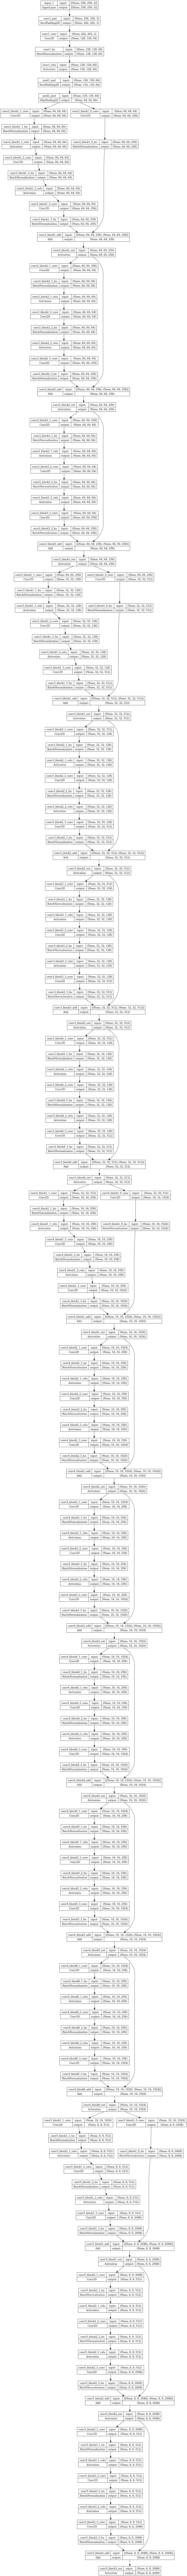

In [4]:
plot_model(resnet50, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [5]:
from tensorflow.keras.models import Model

In [6]:
block_1to3 = Model(inputs = resnet50.get_layer("conv2_block1_1_conv").input,outputs=resnet50.get_layer("conv2_block3_out").output)

In [7]:
block_3to4 = Model(inputs = resnet50.get_layer("conv3_block2_1_conv").input,outputs=resnet50.get_layer("conv3_block4_out").output)

In [8]:
block_4to6 = Model(inputs = resnet50.get_layer("conv4_block2_1_conv").input,outputs=resnet50.get_layer("conv4_block6_out").output)

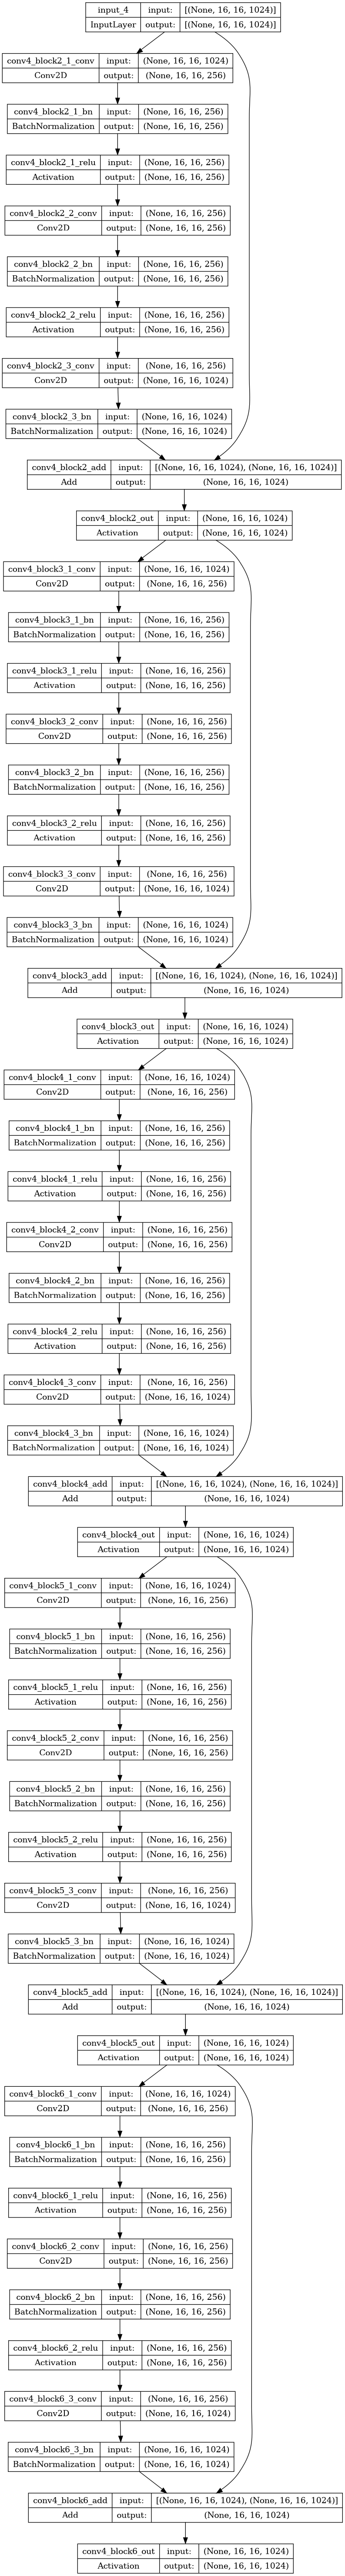

In [9]:
plot_model(block_4to6, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [10]:
!pip install tensorflow-wavelets

In [11]:
#Im excluding HH....very little information in this band
import pywt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow_wavelets.utils.helpers import *
import tensorflow_wavelets.Layers.DWT as DWT
import tensorflow_wavelets.Layers.DTCWT as DTCWT
import tensorflow_wavelets.Layers.DMWT as DMWT
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # for tensor flow warning
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'


class DWT(layers.Layer):
    """
    Discrete Wavelet transform - tensorflow - keras
    inputs:
        name - wavelet name ( from pywavelet library)
        concat - 1 - merge transform output to one channel
               - 0 - split to 4 channels ( 1 img in -> 4 smaller img out)
    """

    def __init__(self, wavelet_name='haar', concat=1, **kwargs):
        super(DWT, self).__init__(**kwargs)
        # self._name = self.name + "_" + name
        # get filter coeffs from 3rd party lib
        wavelet = pywt.Wavelet(wavelet_name)
        self.dec_len = wavelet.dec_len
        self.concat = concat
        # decomposition filter low pass and hight pass coeffs
        db2_lpf = wavelet.dec_lo
        db2_hpf = wavelet.dec_hi

        # covert filters into tensors and reshape for convolution math
        db2_lpf = tf.constant(db2_lpf[::-1])
        self.db2_lpf = tf.reshape(db2_lpf, (1, wavelet.dec_len, 1, 1))

        db2_hpf = tf.constant(db2_hpf[::-1])
        self.db2_hpf = tf.reshape(db2_hpf, (1, wavelet.dec_len, 1, 1))

        self.conv_type = "VALID"
        self.border_padd = "SYMMETRIC"

    def build(self, input_shape):
        # filter dims should be bigger if input is not gray scale
        if input_shape[-1] != 1:
            # self.db2_lpf = tf.repeat(self.db2_lpf, input_shape[-1], axis=-1)
            self.db2_lpf = tf.keras.backend.repeat_elements(self.db2_lpf, input_shape[-1], axis=-1)
            # self.db2_hpf = tf.repeat(self.db2_hpf, input_shape[-1], axis=-1)
            self.db2_hpf = tf.keras.backend.repeat_elements(self.db2_hpf, input_shape[-1], axis=-1)

    def call(self, inputs, training=None, mask=None):

        # border padding symatric add coulums
        inputs_pad = tf.pad(inputs, [[0, 0], [0, 0], [self.dec_len-1, self.dec_len-1], [0, 0]], self.border_padd)

        # approximation conv only rows
        a = tf.nn.conv2d(
            inputs_pad, self.db2_lpf, padding=self.conv_type, strides=[1, 1, 1, 1],
        )
        # details conv only rows
        d = tf.nn.conv2d(
            inputs_pad, self.db2_hpf, padding=self.conv_type, strides=[1, 1, 1, 1],
        )
        # ds - down sample
        a_ds = a[:, :, 1:a.shape[2]:2, :]
        d_ds = d[:, :, 1:d.shape[2]:2, :]

        # border padding symatric add rows
        a_ds_pad = tf.pad(a_ds, [[0, 0], [self.dec_len-1, self.dec_len-1], [0, 0], [0, 0]], self.border_padd)
        d_ds_pad = tf.pad(d_ds, [[0, 0], [self.dec_len-1, self.dec_len-1], [0, 0], [0, 0]], self.border_padd)

        # convolution is done on the rows so we need to
        # transpose the matrix in order to convolve the colums
        a_ds_pad = tf.transpose(a_ds_pad, perm=[0, 2, 1, 3])
        d_ds_pad = tf.transpose(d_ds_pad, perm=[0, 2, 1, 3])

        # aa approximation approximation
        aa = tf.nn.conv2d(
            a_ds_pad, self.db2_lpf, padding=self.conv_type, strides=[1, 1, 1, 1],
        )
        # ad approximation details
        ad = tf.nn.conv2d(
            a_ds_pad, self.db2_hpf, padding=self.conv_type, strides=[1, 1, 1, 1],
        )
        # ad details aproximation
        da = tf.nn.conv2d(
            d_ds_pad, self.db2_lpf, padding=self.conv_type, strides=[1, 1, 1, 1],
        )
        # dd details details
        dd = tf.nn.conv2d(
            d_ds_pad, self.db2_hpf, padding=self.conv_type, strides=[1, 1, 1, 1],
        )

        # transpose back the matrix
        aa = tf.transpose(aa, perm=[0, 2, 1, 3])
        ad = tf.transpose(ad, perm=[0, 2, 1, 3])
        da = tf.transpose(da, perm=[0, 2, 1, 3])
        dd = tf.transpose(dd, perm=[0, 2, 1, 3])

        # down sample
        ll = aa[:, 1:aa.shape[1]:2, :, :]
        lh = ad[:, 1:ad.shape[1]:2, :, :]
        hl = da[:, 1:da.shape[1]:2, :, :]
        hh = dd[:, 1:dd.shape[1]:2, :, :]

        # concate all outputs ionto tensor
        if self.concat == 0:
            #x = tf.concat([ll, lh, hl, hh], axis=-1)
            x = tf.concat([ll, lh, hl], axis=-1)
        else:
            #x = tf.concat([tf.concat([ll, lh], axis=1), tf.concat([hl, hh], axis=1)], axis=2)
            x = ll
        return x

In [12]:
#defining model architecture
#I find this to a continuation of the W-Net in many ways...instead of using two encoders were basically breaking open a pretrained encoder to integrate blocks that will be trained from scratch
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input, Dropout, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50

def conv_block(inputs, num_filters):
    x = BatchNormalization()(inputs)
    s = Conv2D(num_filters, 1, padding="same", strides=1,kernel_initializer="he_normal")(inputs)
    x = Activation("relu")(x)
    x = Conv2D(num_filters, 3, padding="same",kernel_initializer="he_normal")(x)
    x = Dropout(0.01)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(num_filters, 3, padding="same",kernel_initializer="he_normal")(x)

    return x + s

def decoder_block(inputs, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(inputs)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def DWT_pooling_block(inputs,num_filters,i):
    #there were instantiation issues while using this custom defined layer...so each layer has to be given a name manually...i is for that 
    #purpose
    p = DWT(wavelet_name="db1",concat=0,name = 'pool_'+ str(i))(inputs)
    p = conv_block(p,num_filters)
    return p
    
def build_Y_Net(input_shape):
    """ Input """
    inputs = Input(input_shape)

    """ Pre-trained ResNet50 Model """
    resnet50 = ResNet50(include_top=False, weights="imagenet", input_tensor=inputs)
    for layer in resnet50.layers:
        layer.trainable=True
        
    """Encoder 1"""
    x = Conv2D(64, 3, padding="same", strides=1,kernel_initializer="he_normal")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(64, 3, padding="same", strides=1,kernel_initializer="he_normal")(x)
    s = Conv2D(64, 1, padding="same", strides=1,kernel_initializer="he_normal")(inputs)

    c1 = x + s
    p1 = DWT(wavelet_name='db1', concat=0, name='pool_1')(c1)#pooling operation
    s1 = c1# skip connection

    """Encoder 2"""
    c2 = conv_block(p1,128)
    p2 = DWT(wavelet_name='db1', concat=0, name='pool_2')(c2)#pooling operation....instantiation is important...name them correctly
    s2 = c2# skip connection 
    """Encoder 3"""
    block_1to3 = Model(inputs = resnet50.get_layer("conv2_block1_1_conv").input,outputs=resnet50.get_layer("conv2_block3_out").output)
    c3 = block_1to3(Conv2D(64, 1, padding="same", strides=1,kernel_initializer="he_normal")(p2))
    p3 = DWT(wavelet_name='db1', concat=0, name='pool_3')(c3)#pooling operation....instantiation is important...name them correctly
    s3 = c3# skip connection 
    """Encoder 4"""
    block_3to4 = Model(inputs = resnet50.get_layer("conv3_block2_1_conv").input,outputs=resnet50.get_layer("conv3_block4_out").output)
    c4 = block_3to4(Conv2D(512, 1, padding="same", strides=1,kernel_initializer="he_normal")(p3))
    p4 = DWT(wavelet_name='db1', concat=0, name='pool_4')(c4)#pooling operation....instantiation is important...name them correctly
    s4 = c4# skip connection 
    
    """Bottleneck"""
    block_4to6 = Model(inputs = resnet50.get_layer("conv4_block2_1_conv").input,outputs=resnet50.get_layer("conv4_block6_out").output)
    b = block_4to6(Conv2D(1024, 1, padding="same", strides=1,kernel_initializer="he_normal")(p4))

    """ Decoder """
    d1 = decoder_block(b, s4, 512)                     
    d2 = decoder_block(d1, s3, 256)                     
    d3 = decoder_block(d2, s2, 128)                    
    d4 = decoder_block(d3, s1, 64)                      
    
    """Classifier"""
    classifier_arm = Flatten()(b)
    classifier_arm = Dense(256, activation='relu')(classifier_arm)
    classifier_output = Dense(1, activation='sigmoid', name='classifier_output')(classifier_arm)

    """ Seg_Output """
    segmentation_output = Conv2D(1, 1, padding="same", activation="sigmoid",name = 'segmentation_output')(d4)

    model = Model(inputs=inputs, outputs=[segmentation_output, classifier_output], name="composite_model")
    return model


In [13]:
#some metrics 
from keras import backend as K
epsilon = 1e-5
smooth = 1

def dice_coeff(y_true, y_pred, smooth=1):
    y_true_flatten = K.flatten(y_true)
    y_pred_flatten = K.flatten(y_pred)
    intersection = K.sum(y_true_flatten * y_pred_flatten)
    dice = (2. * intersection + smooth) / (K.sum(y_true_flatten) + K.sum(y_pred_flatten) + smooth)
    return dice
def dice_loss(y_true, y_pred, smooth=1):
    return  1- dice_coeff(y_true, y_pred, smooth=1)

def FocalLoss(targets, inputs, alpha=0.8, gamma=2):    
    
    inputs = K.flatten(inputs)
    targets = K.flatten(targets)
    
    BCE = K.binary_crossentropy(targets, inputs)
    BCE_EXP = K.exp(-BCE)
    focal_loss = K.mean(alpha * K.pow((1-BCE_EXP), gamma) * BCE)
    
    return focal_loss

def total_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    return dice_loss(y_true, y_pred, smooth=1) + FocalLoss(y_true, y_pred, 0.25,2)
def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

def iou(y_true, y_pred):
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true + y_pred, axis=[1, 2, 3]) - intersection
    iou = (intersection + 1e-7) / (union + 1e-7)
    return iou


In [14]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
# Build the model
input_shape = (256,256,3)  # Assuming RGB images
model = build_Y_Net(input_shape)

In [15]:
model.summary()

Model: "composite_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         1792      ['input_5[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 256, 256, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 256, 256, 64)         0         ['batch_normaliz

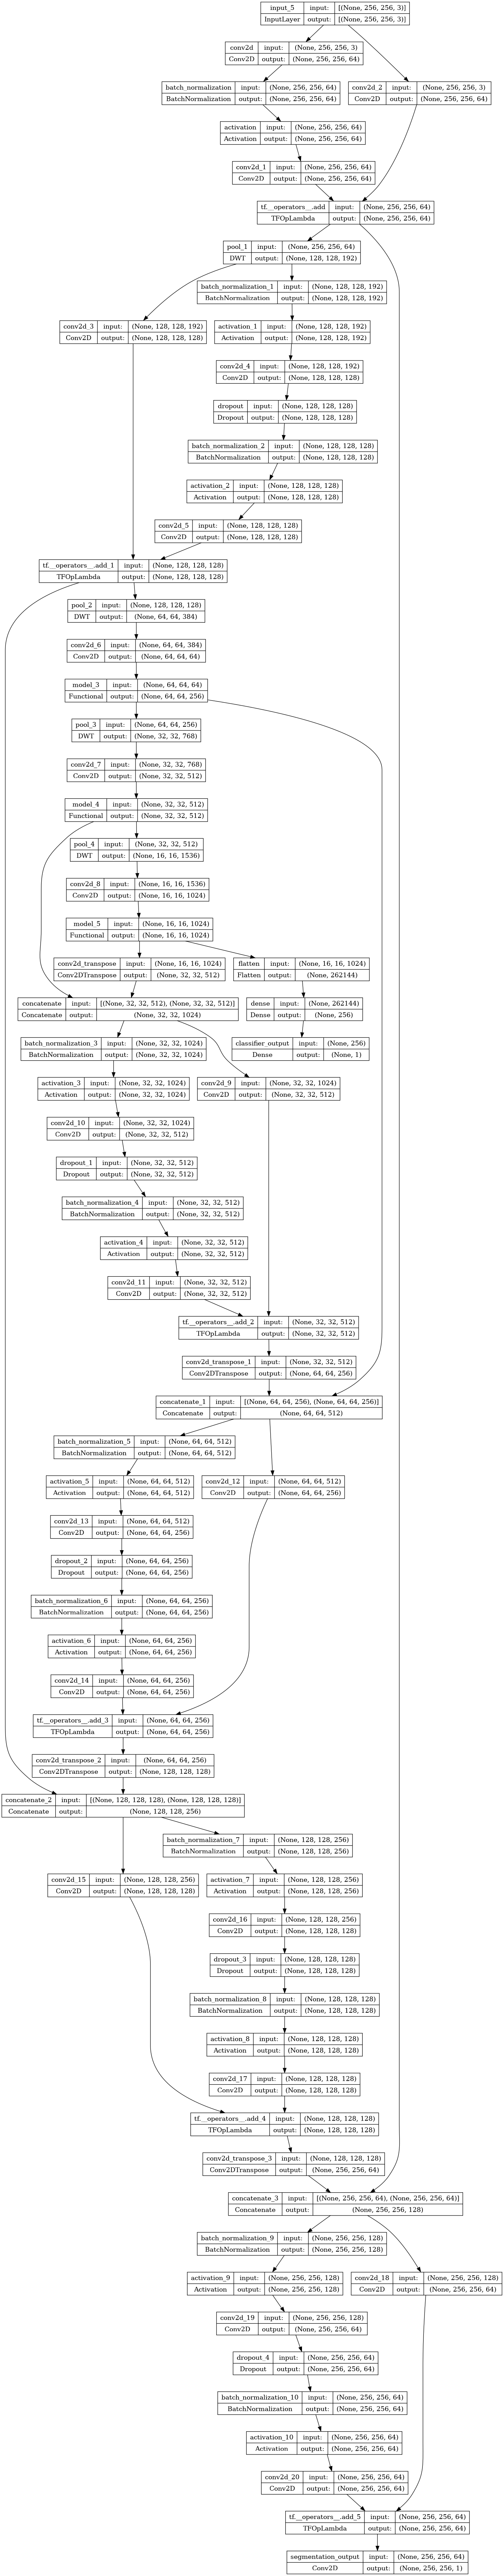

In [16]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)